In [1]:
using Cxx
using PyCall
using PyPlot
import Images
import StatsBase

@pyimport imageio
@pyimport skimage.filters as filters
@pyimport skimage.morphology as morphology
disk = morphology.disk;

In [2]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

In [409]:
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180329160010.mp4"
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_p2.mp4"

"/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_p2.mp4"

In [412]:
reader = imageio.get_reader(video_file);
frames = [T.preprocess_frame(reader[:get_data](i)) for i in 1:2:400];

@time background = T.init_background(frames[1:min(300, size(frames, 1))]; max_iters=3);

 58.005743 seconds (392.20 k allocations: 22.823 GiB, 3.28% gc time)


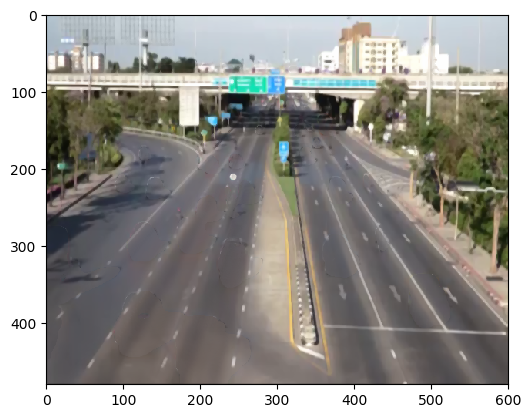

PyObject <matplotlib.image.AxesImage object at 0x7f3983637f28>

In [414]:
imshow(background)

In [415]:
threshold = 0.05;

In [625]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

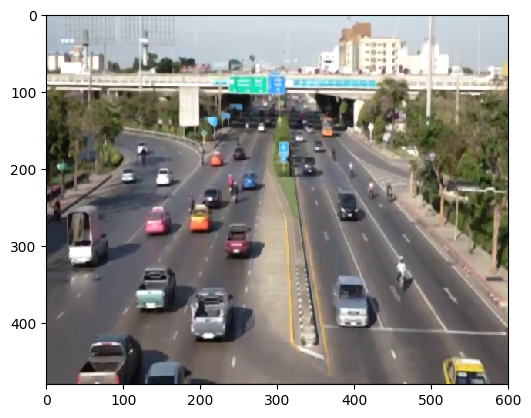

In [751]:
frame = T.preprocess_frame(reader[:get_data](50));
imshow(frame);

In [825]:
adj_threshold = 0.5;
size_threshold = 0.5;

In [827]:
# foreground = T.subtract_background(frame, background, threshold);
# foreground = T.suppress_shadows(foreground, frame, background, z_threshold=1.5, adj_threshold=0.3)

# imshow(frame .* foreground);

In [828]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

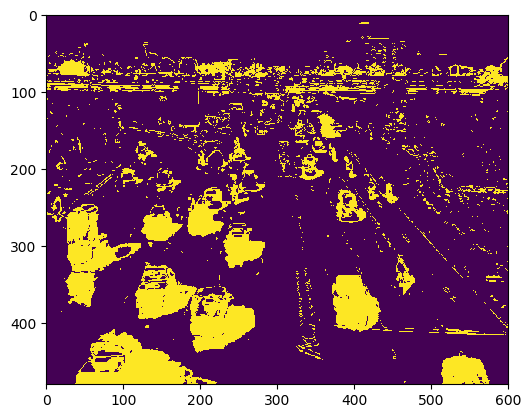

In [829]:
foreground = T.subtract_background(frame, background, threshold);
foreground, shadow_mask = T.suppress_shadows(foreground, frame, background, z_threshold=1.2, adj_threshold=0.3)

imshow(foreground);

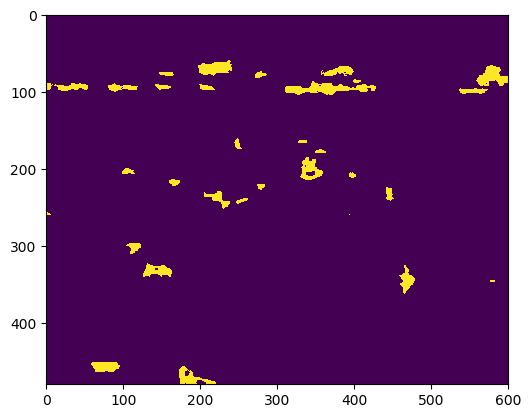

In [842]:
shadow_labels = T.segment_shadows(frame, shadow_mask);

adj_foreground_ratio = T._find_adjacent_foreground_ratio(shadow_labels, foreground)
shadow_mask = vcat(false, adj_foreground_ratio .< adj_threshold)[shadow_labels .+ 1];
imshow(shadow_mask);

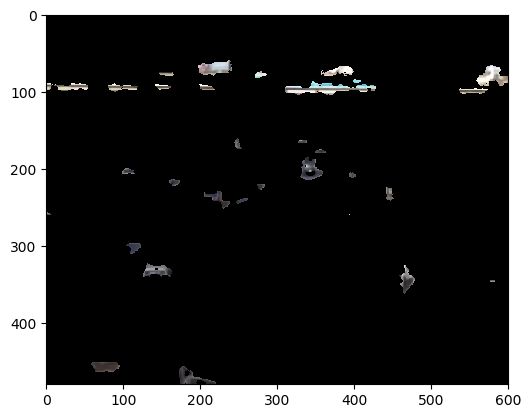

PyObject <matplotlib.image.AxesImage object at 0x7f39807bc320>

In [843]:
imshow(frame .* shadow_mask)

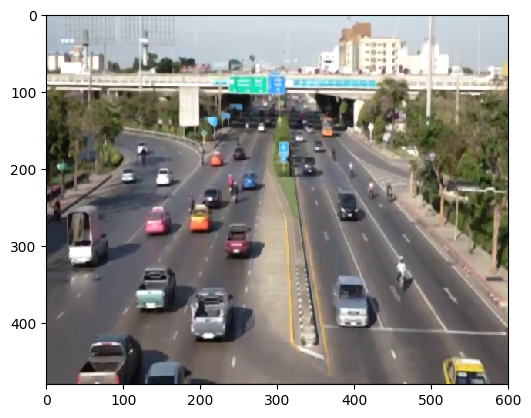

PyObject <matplotlib.image.AxesImage object at 0x7f39811c2940>

In [844]:
imshow(frame)

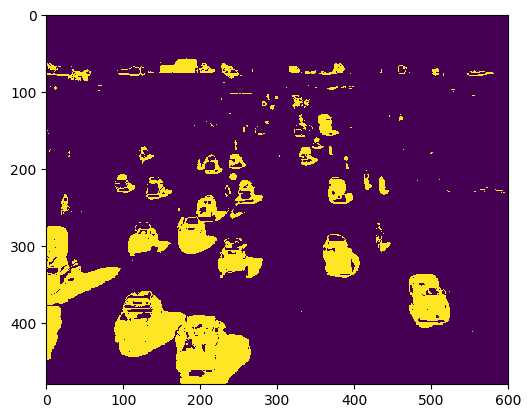

PyObject <matplotlib.image.AxesImage object at 0x7f398067d0f0>

In [733]:
imshow(foreground .& .!shadow_mask)

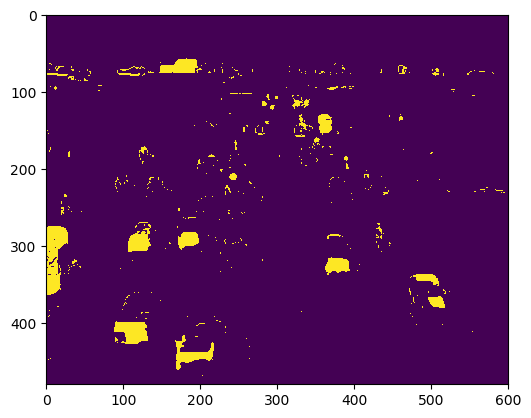

PyObject <matplotlib.image.AxesImage object at 0x7f39839f0128>

In [678]:
imshow(foreground .& .!shadow_mask)

### Step by step

In [601]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

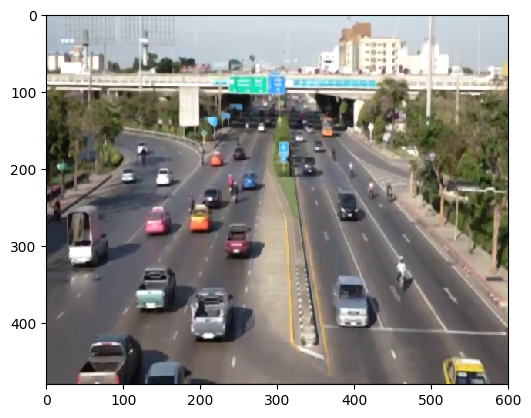

PyObject <matplotlib.image.AxesImage object at 0x7f39807b0f28>

In [798]:
imshow(frame)

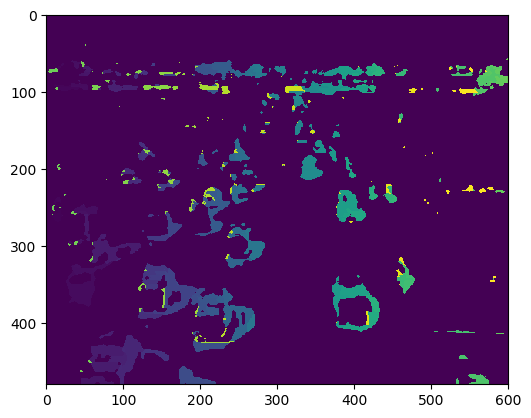

In [816]:
z_threshold = 1.5
adj_threshold = 0.3

d_rows = [0 1 1 1 0 -1 -1 -1]
d_cols = [-1 -1 0 1 1 1 0 -1]

foreground = T.subtract_background(frame, background, threshold);

frame_ratio = (frame + 1 / 256) ./ (background + 1 / 256);
foreground_ratio_pixels = hcat([frame_ratio[:,:,i][foreground] for i in 1:3]...);

std_est = mapslices(p -> StatsBase.mad(p; normalize=true), foreground_ratio_pixels, 1);
ratio_score = (foreground_ratio_pixels .- median(foreground_ratio_pixels, 1)) ./ std_est
shadow_mask_flatten = all(abs.(ratio_score) .< z_threshold, 2);

comp_diffs = [foreground_ratio_pixels[:,i] .- foreground_ratio_pixels[:,j] for (i,j) in [(1,2), (2, 3), (1, 3)]];
shadow_mask_flatten .&= (maximum(abs.(hcat(comp_diffs...)), 2) .< 0.2);

shadow_mask = falses(size(frame)[1:2]);
shadow_mask[foreground] .= vec(shadow_mask_flatten);
shadow_mask = filters.median(shadow_mask, disk(3)) .> 0;
shadow_labels = T.segment_shadows(frame, shadow_mask, edge_threshold=0.05);
n_labels = maximum(shadow_labels)

# imshow(foreground .& .!shadow_mask);

imshow(shadow_labels);

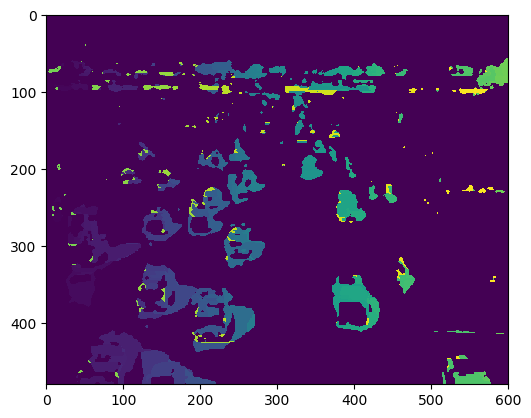

In [794]:
z_threshold = 1.5
adj_threshold = 0.3

d_rows = [0 1 1 1 0 -1 -1 -1]
d_cols = [-1 -1 0 1 1 1 0 -1]

foreground = T.subtract_background(frame, background, threshold);

frame_ratio = (frame + 1 / 256) ./ (background + 1 / 256);
foreground_ratio_pixels = hcat([frame_ratio[:,:,i][foreground] for i in 1:3]...);

std_est = mapslices(p -> StatsBase.mad(p; normalize=true), foreground_ratio_pixels, 1);
ratio_score = (foreground_ratio_pixels .- median(foreground_ratio_pixels, 1)) ./ std_est

comp_diffs = [foreground_ratio_pixels[:,i] .- foreground_ratio_pixels[:,j] for (i,j) in [(1,2), (2, 3), (1, 3)]];
ratio_score .&= maximum(abs.(hcat(comp_diffs...)), 2) .< 0.1;

shadow_mask_flatten = all(abs.(ratio_score) .< z_threshold, 2);
shadow_mask = falses(size(frame)[1:2]);
shadow_mask[foreground] .= vec(shadow_mask_flatten);
shadow_mask = filters.median(shadow_mask, disk(3)) .> 0;
shadow_labels = T.segment_shadows(frame, shadow_mask, edge_threshold=0.05);
n_labels = maximum(shadow_labels)

# imshow(foreground .& .!shadow_mask);

imshow(shadow_labels);

In [592]:
fg_labels = Images.label_components(foreground .& .!shadow_mask) .+ 1;
pixels_per_fg_label = zeros(Int, maximum(fg_labels));
for lab in fg_labels
    pixels_per_fg_label[lab] += 1
end

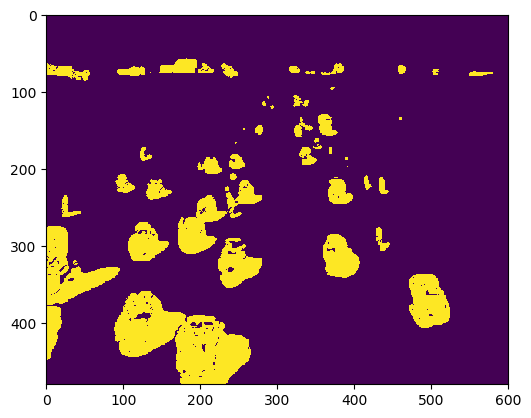

In [593]:
false_fg_mask = (pixels_per_fg_label .< 0.5 * (mean(pixels_per_fg_label[2:end]) + std(pixels_per_fg_label[2:end])))[fg_labels]
foreground[false_fg_mask] = false
imshow(foreground);

In [594]:
border_per_label = zeros(Int, n_labels);
adj_foreground_per_label = zeros(Int, n_labels);

for row in 1:size(frame, 1)
    for col in 1:size(frame, 2)
        const cur_class = shadow_labels[row, col]
        if cur_class == 0
            continue
        end
        
        is_border = false
        for (dr, dc) in zip(d_rows, d_cols)
            row_n = row + dr
            col_n = col + dc
            if row_n < 1 || col_n < 1 || row_n > size(frame, 1) || col_n > size(frame, 2)
                continue
            end
            
            if shadow_labels[row_n, col_n] == cur_class
                continue
            end
            
            if !is_border
                is_border = true
                border_per_label[cur_class] += 1
            end
            
            if foreground[row_n, col_n] && shadow_labels[row_n, col_n] == 0
                adj_foreground_per_label[cur_class] += 1
                break
            end
        end
    end
end

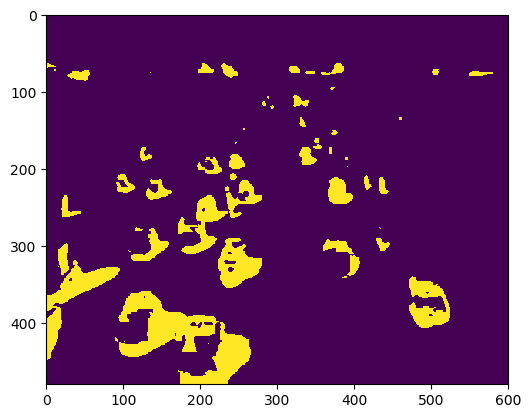

PyObject <matplotlib.image.AxesImage object at 0x7f39828f90f0>

In [595]:
shadow_mask2 = vcat(false, (adj_foreground_per_label ./ border_per_label .< adj_threshold))[shadow_labels .+ 1];
# foreground = filters.median(foreground .& .!shadow_mask, disk(5))
imshow(shadow_mask2)

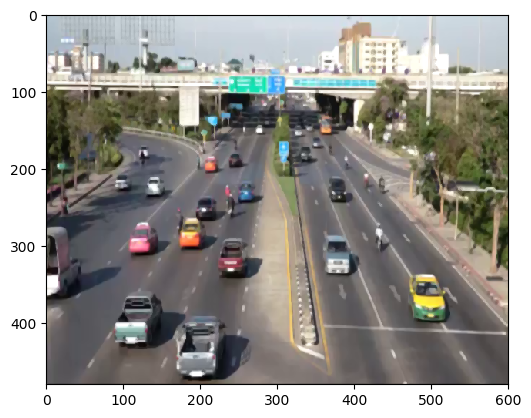

PyObject <matplotlib.image.AxesImage object at 0x7f3982a9acc0>

In [596]:
imshow(frame)

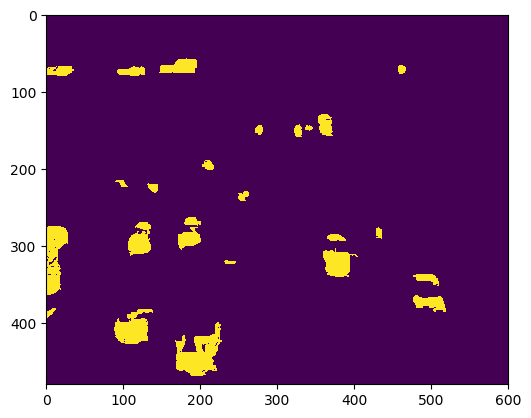

In [597]:
imshow(foreground .& .!shadow_mask2);